<a href="https://colab.research.google.com/github/mithil2311/Time_Series_Stock_Price_Forecast_/blob/version1.2/V121of_Time_Series_Stock_Price_Forecast_using_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [0]:
plt.rcParams["figure.figsize"] = (12, 6)

Download stock price data from NSE [website](https://www.nseindia.com/products/content/equities/equities/eq_security.htm). Here I download stock price data for TCS stock.


In [226]:
df = pd.read_csv("tcsstock.csv")
df.head()



,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,TCS,EQ,21-Aug-2017,2513.80,2505.5,2549.00,2494.30,2513.20,2528.80,2534.62,1152417,2.920942e+09,54265,747946,64.90
1,TCS,EQ,22-Aug-2017,2528.80,2523.0,2539.50,2492.00,2500.00,2497.55,2516.08,565663,1.423252e+09,35029,287383,50.80
2,TCS,EQ,23-Aug-2017,2497.55,2505.0,2516.80,2473.15,2491.60,2489.45,2487.52,781136,1.943094e+09,39129,512785,65.65
3,TCS,EQ,24-Aug-2017,2489.45,2497.7,2517.95,2486.15,2498.05,2496.60,2495.82,811954,2.026487e+09,42614,596982,73.52
4,TCS,EQ,28-Aug-2017,2496.60,2504.6,2505.40,2461.00,2491.00,2487.30,2479.76,1018398,2.525379e+09,54931,696983,68.44


Check whether you have duplicate data on by date. It looks like 11/2/2019, 18/2/2019, 25/2/2019 etc. have duplicate data. Not sure why there are duplicates by date. It could be ammendment to the data.

In [180]:
df[df["Date"].duplicated(keep = False)]

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
366,TCS,BL,11-Feb-2019,2604.20,2061.40,2061.40,2061.40,2061.40,2061.40,2061.40,376308,7.757213e+08,1,0,0.00
367,TCS,EQ,11-Feb-2019,2061.40,2060.00,2096.00,2048.90,2065.60,2065.90,2077.11,1778730,3.694622e+09,83603,901516,50.68
372,TCS,BL,18-Feb-2019,2061.40,2029.70,2029.70,2029.70,2029.70,2029.70,2029.70,2474600,5.022696e+09,1,0,0.00
373,TCS,EQ,18-Feb-2019,2029.70,2037.60,2041.95,1962.65,1969.60,1970.30,1988.87,2942184,5.851634e+09,100585,1668905,56.72
378,TCS,BL,25-Feb-2019,2029.70,1925.65,1925.65,1925.65,1925.65,1925.65,1925.65,1057509,2.036392e+09,2,0,0.00
379,TCS,EQ,25-Feb-2019,1925.65,1932.50,1990.00,1930.50,1987.00,1985.15,1961.61,2934880,5.757095e+09,140541,1341508,45.71
396,TCS,BL,22-Mar-2019,1925.65,2015.05,2015.05,2015.05,2015.05,2015.05,2015.05,264913,5.338129e+08,1,264913,100.00
397,TCS,EQ,22-Mar-2019,2015.05,2015.00,2016.00,1983.30,2010.00,2005.65,1998.96,3148149,6.293032e+09,155770,1787595,56.78


Drop the duplicate from the dataset.

In [0]:
df = df[~df["Date"].duplicated()]

Convert the dataset into time series data by undating the index to time series index. 

In [182]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,,,,
2017-08-21,TCS,EQ,21-Aug-2017,2513.80,2505.5,2549.00,2494.30,2513.20,2528.80,2534.62,1152417,2.920942e+09,54265,747946,64.90
2017-08-22,TCS,EQ,22-Aug-2017,2528.80,2523.0,2539.50,2492.00,2500.00,2497.55,2516.08,565663,1.423252e+09,35029,287383,50.80
2017-08-23,TCS,EQ,23-Aug-2017,2497.55,2505.0,2516.80,2473.15,2491.60,2489.45,2487.52,781136,1.943094e+09,39129,512785,65.65
2017-08-24,TCS,EQ,24-Aug-2017,2489.45,2497.7,2517.95,2486.15,2498.05,2496.60,2495.82,811954,2.026487e+09,42614,596982,73.52
2017-08-28,TCS,EQ,28-Aug-2017,2496.60,2504.6,2505.40,2461.00,2491.00,2487.30,2479.76,1018398,2.525379e+09,54931,696983,68.44


In [183]:
df.index

DatetimeIndex(['2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-04',
               ...
               '2019-08-02', '2019-08-05', '2019-08-06', '2019-08-07',
               '2019-08-08', '2019-08-09', '2019-08-13', '2019-08-14',
               '2019-08-16', '2019-08-19'],
              dtype='datetime64[ns]', name='Date', length=493, freq=None)

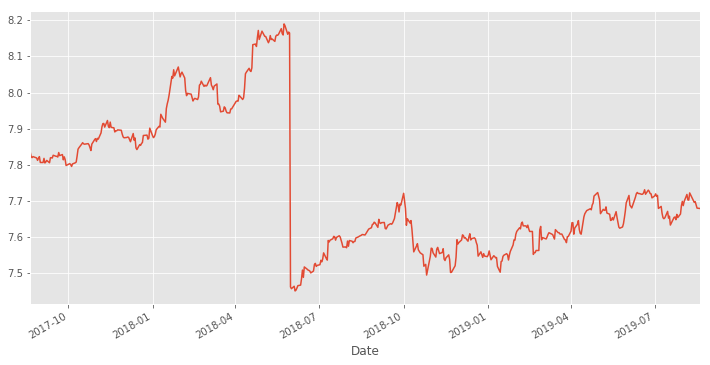

In [184]:
y = np.log(df["Close Price"])
y.plot()

In [185]:
y.index

DatetimeIndex(['2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-04',
               ...
               '2019-08-02', '2019-08-05', '2019-08-06', '2019-08-07',
               '2019-08-08', '2019-08-09', '2019-08-13', '2019-08-14',
               '2019-08-16', '2019-08-19'],
              dtype='datetime64[ns]', name='Date', length=493, freq=None)

Let's see if there are gaps in the data in terms of date range. Trading does not happen on weekends or national holidays. So there is no data on those days. 

In [186]:
list(y.index[:10])

[Timestamp('2017-08-21 00:00:00'),
 Timestamp('2017-08-22 00:00:00'),
 Timestamp('2017-08-23 00:00:00'),
 Timestamp('2017-08-24 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-29 00:00:00'),
 Timestamp('2017-08-30 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-09-04 00:00:00')]

In [187]:
y.asfreq("D")[:15]

Date
2017-08-21    7.835500
2017-08-22    7.823066
2017-08-23    7.819817
2017-08-24    7.822685
2017-08-25         NaN
2017-08-26         NaN
2017-08-27         NaN
2017-08-28    7.818953
2017-08-29    7.812317
2017-08-30    7.817847
2017-08-31    7.822585
2017-09-01    7.806472
2017-09-02         NaN
2017-09-03         NaN
2017-09-04    7.806371
Freq: D, Name: Close Price, dtype: float64

Let's impute the missing data by forward fill using asfreq method.

In [188]:
y.asfreq("D", method="ffill")[:15]

Date
2017-08-21    7.835500
2017-08-22    7.823066
2017-08-23    7.819817
2017-08-24    7.822685
2017-08-25    7.822685
2017-08-26    7.822685
2017-08-27    7.822685
2017-08-28    7.818953
2017-08-29    7.812317
2017-08-30    7.817847
2017-08-31    7.822585
2017-09-01    7.806472
2017-09-02    7.806472
2017-09-03    7.806472
2017-09-04    7.806371
Freq: D, Name: Close Price, dtype: float64

For legitimate gaps, we can also set frequency to business days ("B")

In [189]:
y = y.asfreq("B")
y.index

DatetimeIndex(['2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24',
               '2017-08-25', '2017-08-28', '2017-08-29', '2017-08-30',
               '2017-08-31', '2017-09-01',
               ...
               '2019-08-06', '2019-08-07', '2019-08-08', '2019-08-09',
               '2019-08-12', '2019-08-13', '2019-08-14', '2019-08-15',
               '2019-08-16', '2019-08-19'],
              dtype='datetime64[ns]', name='Date', length=521, freq='B')

Calculate quarterly high, low etc. 

In [190]:
pd.DataFrame(dict(low=y.resample("Q").min(), 
                  high=y.resample("Q").max(), 
                  first = y.resample("Q").first(), 
                  last = y.resample("Q").last(),
                  median = y.resample("Q").median(),
                  mean = y.resample("Q").mean()
                 ))

,low,high,first,last,median,mean
Date,,,,,,
2017-09-30,7.798092,7.835500,7.835500,7.798092,7.819415,7.818055
2017-12-31,7.795482,7.922605,7.803210,7.901451,7.871711,7.868971
2018-03-31,7.875195,8.070547,7.880653,7.954776,7.985789,7.983002
2018-06-30,7.451009,8.189716,7.975788,7.521724,8.057124,7.897523
2018-09-30,7.523670,7.695508,7.523670,7.688776,7.602676,7.607829
2018-12-31,7.495042,7.721149,7.721149,7.545945,7.567837,7.572861
2019-03-31,7.502876,7.641516,7.551082,7.601727,7.593789,7.585512
2019-06-30,7.608126,7.731031,7.616604,7.708500,7.674339,7.675082
2019-09-30,7.633345,7.722279,7.714030,7.679251,7.679760,7.680289


Calculate rolling mean, exponentially weighted mean

In [193]:
period = 1
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.head(10)

,actual,rolling_mean,ewm
Date,,,
2017-08-21,7.835500,7.835500,7.835500
2017-08-22,7.823066,7.823066,7.823066
2017-08-23,7.819817,7.819817,7.819817
2017-08-24,7.822685,7.822685,7.822685
2017-08-25,NaN,NaN,7.822685
2017-08-28,7.818953,7.818953,7.818953
2017-08-29,7.812317,7.812317,7.812317
2017-08-30,7.817847,7.817847,7.817847
2017-08-31,7.822585,7.822585,7.822585


In [194]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  3.4591507385679722e-15
rmse over ewma:  0.0


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test. 

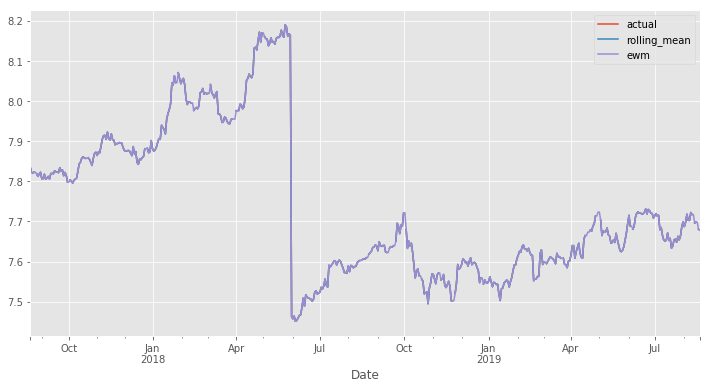

In [195]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary. 

In [196]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.091259
p-value: 0.248044


In [197]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2017-08-21,7.835500,NaN,NaN
2017-08-22,7.823066,NaN,NaN
2017-08-23,7.819817,NaN,NaN
2017-08-24,7.822685,-0.012815,NaN
2017-08-25,NaN,NaN,NaN
2017-08-28,7.818953,-0.000864,NaN
2017-08-29,7.812317,-0.010368,-0.009504
2017-08-30,7.817847,NaN,NaN
2017-08-31,7.822585,0.003632,NaN


In [198]:
result = adfuller(y.diff(periods=1).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -21.475008
p-value: 0.000000


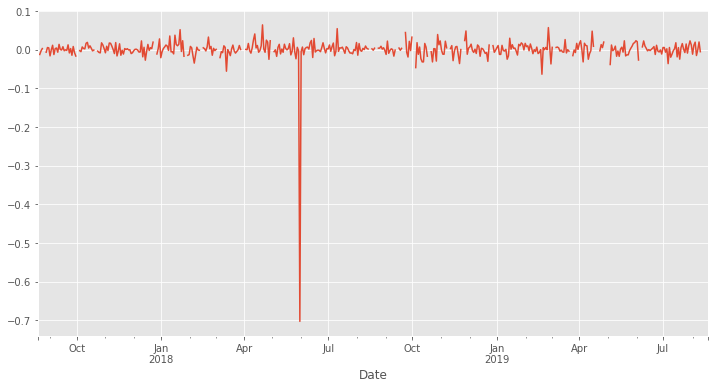

In [199]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the [autocorrelation plot](https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show) 

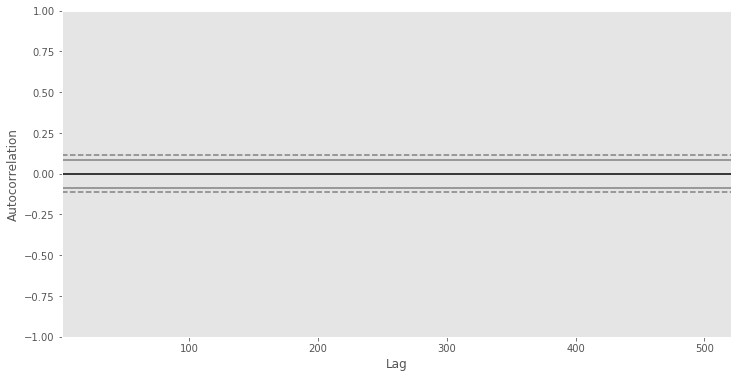

In [200]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [0]:
y = y.dropna()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                  0
count  4.920000e+02
mean  -4.881413e-07
std    3.495122e-02
min   -6.996316e-01
25%   -6.639383e-03
50%    1.159807e-03
75%    9.319367e-03
max    6.465064e-02


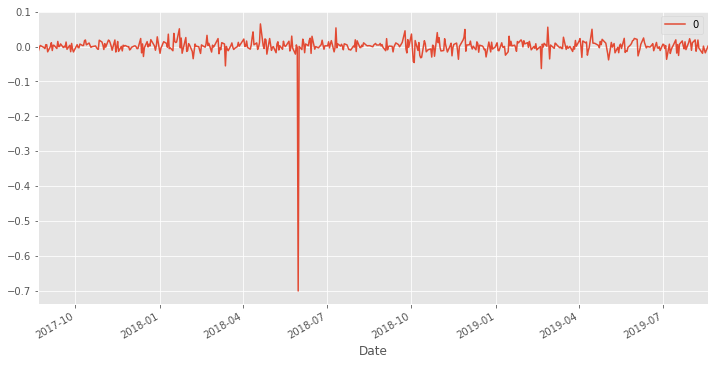

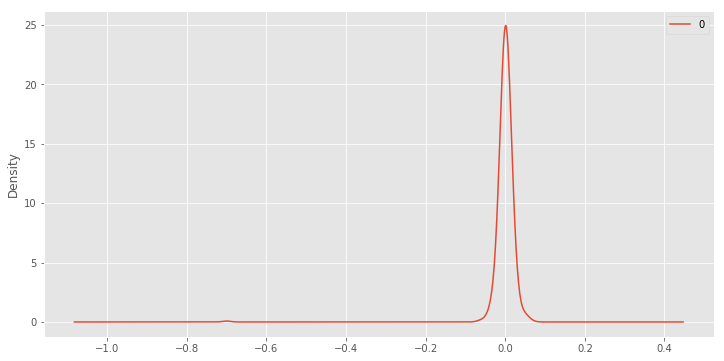

In [202]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(y, order=(5,1,0)) # p, d, q
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [203]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Close Price   No. Observations:                  492
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 952.446
Method:                       css-mle   S.D. of innovations              0.035
Date:                Tue, 27 Aug 2019   AIC                          -1890.893
Time:                        09:40:07   BIC                          -1861.504
Sample:                             1   HQIC                         -1879.353
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0003      0.002     -0.198      0.843      -0.003       0.003
ar.L1.D.Close Price     0.0071      0.045      0.158      0.875      -0.081       0.095
ar.L2.D.Close Price    -0.0216      0.045     -0.481      0.631      -0.110       0.067
ar.L3.D.Close Price     0.0481      0.045      1.071      0.285      -0.040       0.136
ar.L4.D.Close Price     0.0110      0.045      0.244      0.807      -0.077       0.099
ar.L5.D.Close Price    -0.0330      0.045     -0.735      0.463      -0.121       0.055
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0983           -0.0000j            2.0983           -0.5000
AR.2           -0.5650           -1.7371j            1.8267           -0.3000
AR.3           -0.5650           +1.7371j            1.8267            0.3000
AR.4            1.7806           -1.0771j            2.0810           -0.0866
AR.5            1.7806           +1.0771j            2.0810            0.0866
-----------------------------------------------------------------------------
"""

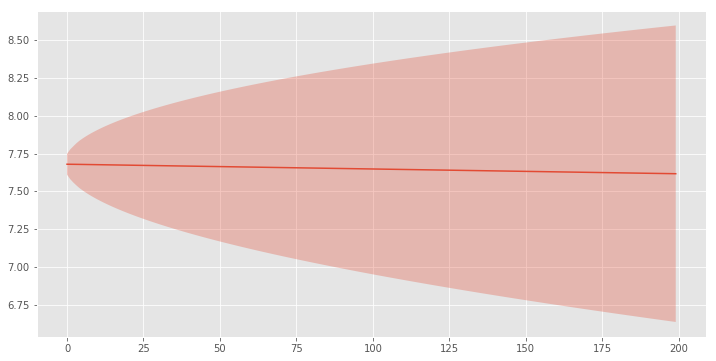

In [204]:
model = ARIMA(y.values, order=(5,1,0))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(200)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [205]:
predictions[:10]

array([7.67937185, 7.67893566, 7.67829937, 7.67858047, 7.67829633,
       7.67793661, 7.67764886, 7.67735275, 7.67701493, 7.67669826])

In [206]:
error[:10]

array([0.03491566, 0.04955365, 0.06032908, 0.07029372, 0.07920573,
       0.08670896, 0.09363003, 0.10010547, 0.10615035, 0.11186028])

In [207]:
conf_interval[:10]

array([[7.61093841, 7.7478053 ],
       [7.58181229, 7.77605902],
       [7.56005655, 7.79654219],
       [7.54080732, 7.81635363],
       [7.52305594, 7.83353671],
       [7.50799018, 7.84788305],
       [7.49413737, 7.86116035],
       [7.48114964, 7.87355586],
       [7.46896407, 7.88506579],
       [7.45745615, 7.89594038]])

In [208]:
model.endog

array([-1.24346306e-02, -3.24844882e-03,  2.86800369e-03, -3.73202143e-03,
       -6.63556381e-03,  5.52933564e-03,  4.73810840e-03, -1.61124468e-02,
       -1.01778063e-04,  1.13956157e-02, -1.26177611e-02,  2.80870475e-03,
        4.25903660e-03, -6.55833256e-03,  1.37573231e-02,  3.01347023e-04,
       -9.04313637e-04,  7.65074831e-03, -2.79714873e-03, -3.20172896e-04,
       -1.88308882e-03,  1.24940600e-02, -8.47176191e-03,  2.85181722e-03,
       -1.44825414e-02,  8.18975732e-03, -7.46264615e-03, -1.64892589e-02,
        5.11834710e-03, -2.51495302e-03, -5.21358352e-03,  6.99310720e-03,
        3.04035331e-03,  2.09633016e-03,  1.65742967e-02,  1.89565055e-02,
        4.07300634e-03,  1.00331388e-02,  3.91971847e-03, -3.06881918e-03,
       -1.04438652e-03,  1.54685053e-03, -3.67768450e-03, -7.20085629e-03,
       -8.25697263e-03,  1.77434557e-02,  1.22682050e-02,  2.97698781e-03,
       -8.09287255e-03,  8.91189681e-03, -2.30641036e-03,  1.71979303e-02,
        1.65566696e-02,  

In [209]:
(predictions + 1.96 * error)[:10]

array([7.74780655, 7.7760608 , 7.79654436, 7.81635616, 7.83353956,
       7.84788617, 7.86116373, 7.87355947, 7.88506961, 7.89594441])

In [210]:
(predictions - 1.96 * error)[:10]

array([7.61093715, 7.58181051, 7.56005438, 7.54080478, 7.52305309,
       7.50798706, 7.494134  , 7.48114603, 7.46896024, 7.45745212])

predicted=7.606888, actual=7.592996
predicted=7.592399, actual=7.592190
predicted=7.591843, actual=7.584722
predicted=7.583383, actual=7.601052
predicted=7.600480, actual=7.601727
predicted=7.600973, actual=7.616604
predicted=7.616939, actual=7.639787
predicted=7.639664, actual=7.639787
predicted=7.639068, actual=7.608126
predicted=7.608748, actual=7.624765
predicted=7.624725, actual=7.635666
predicted=7.632336, actual=7.645637
predicted=7.645484, actual=7.620828
predicted=7.621915, actual=7.610605
predicted=7.610607, actual=7.608126
predicted=7.606239, actual=7.656006
predicted=7.654680, actual=7.664722
predicted=7.663893, actual=7.673246
predicted=7.675430, actual=7.678535
predicted=7.679199, actual=7.675569
predicted=7.673910, actual=7.688661
predicted=7.688549, actual=7.693937
predicted=7.692990, actual=7.713584
predicted=7.713756, actual=7.723275
predicted=7.723217, actual=7.703188
predicted=7.703147, actual=7.664816
predicted=7.665100, actual=7.676868
predicted=7.675930, actual=7

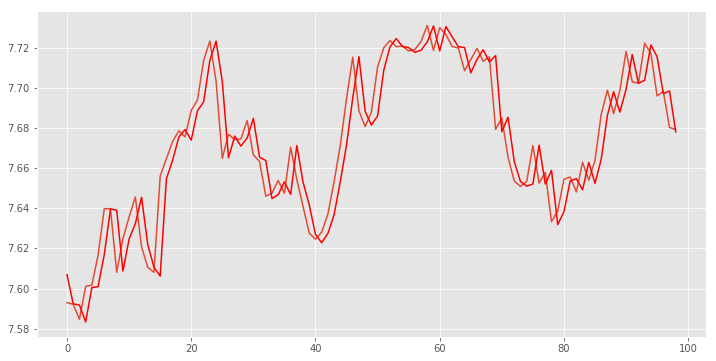

In [211]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.8)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

plt.plot(test)
plt.plot(predictions, color='red')


In [214]:
result = pd.DataFrame(y)[train_size:]
result.columns = ["actual"]
result["prediction"] = predictions
result

,actual,prediction
Date,,
2019-03-25,7.592996,7.606888
2019-03-26,7.592190,7.592399
2019-03-27,7.584722,7.591843
2019-03-28,7.601052,7.583383
2019-03-29,7.601727,7.600480
2019-04-01,7.616604,7.600973
2019-04-02,7.639787,7.616939
2019-04-03,7.639787,7.639664
2019-04-04,7.608126,7.639068


In [0]:
from numpy import array
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [216]:
y_b = np.log(df["Close Price"])
y_b = y_b.asfreq("B").dropna()/10.0
print("%s" % y_b[:10])

Date
2017-08-21    0.783550
2017-08-22    0.782307
2017-08-23    0.781982
2017-08-24    0.782269
2017-08-28    0.781895
2017-08-29    0.781232
2017-08-30    0.781785
2017-08-31    0.782258
2017-09-01    0.780647
2017-09-04    0.780637
Name: Close Price, dtype: float64


In [217]:
n_input = 5
train_size = int(0.8 * len(y_b))
y_b_train = y_b[:train_size]
y_b_test = y_b[train_size:]
generator_train = TimeseriesGenerator(y_b_train, y_b_train, length=n_input, batch_size=1, )
generator_test = TimeseriesGenerator(y_b_test, y_b_test, length=n_input, batch_size=1)
print('Samples: %d' % len(generator_train))
for i in range(3):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

Samples: 389
[[0.78355002 0.78230655 0.78198171 0.78226851 0.78189531]] => [0.78123175]
[[0.78230655 0.78198171 0.78226851 0.78189531 0.78123175]] => [0.78178468]
[[0.78198171 0.78226851 0.78189531 0.78123175 0.78178468]] => [0.78225849]


In [218]:
tf.set_random_seed(1)
np.random.seed(1)


model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (n_input,)),
    keras.layers.Dense(1, activation = None, kernel_initializer = keras.initializers.he_uniform(seed = 1.0))
])
model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 0.1))
model.summary()

model.fit_generator(generator_train, steps_per_epoch=1, epochs=750, verbose=0)
y_b_test_pred = model.predict_generator(generator_test, use_multiprocessing = True)
layer = model.layers[0]
print(layer.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
[array([[-0.3283567 ],
       [-0.4081921 ],
       [-0.2957491 ],
       [ 0.14313756],
       [ 0.9796748 ]], dtype=float32), array([0.72131145], dtype=float32)]


In [219]:
y_b_test_pred.shape, y_b_test.shape

((94, 1), (99,))

In [220]:
metrics.mean_squared_error(y_b_test[n_input:] * 10.0, y_b_test_pred * 10.0) ** 0.5

0.23657455226887722

In [221]:
y_b = y_b_test_pred.flatten()
y_b = y_b_test_pred.reshape((len(y_b), 1))

train_size = int(0.8 * len(y_b))
y_b_train = y_b[:train_size]
y_b_test = y_b[train_size:]

n_input = 5

generator_train = TimeseriesGenerator(y_b_train, y_b_train, length=n_input, batch_size=1, )
generator_test = TimeseriesGenerator(y_b_test, y_b_test, length=n_input, batch_size=1)
print('Samples: %d' % len(generator_train))
for i in range(3):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

Samples: 70
[[[0.79128736]
  [0.7926027 ]
  [0.7946455 ]
  [0.79397357]
  [0.7895569 ]]] => [[0.789299]]
[[[0.7926027 ]
  [0.7946455 ]
  [0.79397357]
  [0.7895569 ]
  [0.789299  ]]] => [[0.7907802]]
[[[0.7946455 ]
  [0.79397357]
  [0.7895569 ]
  [0.789299  ]
  [0.7907802 ]]] => [[0.7927133]]


In [222]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (n_input,1)),
    keras.layers.LSTM(units = 100),
    keras.layers.Dense(units = 1, activation = None)
])
model.compile(loss = "mse", optimizer = "adam")
model.summary()

model.fit_generator(generator_train, steps_per_epoch=1, epochs=750, verbose=1)
y_b_test_pred = model.predict_generator(generator_test)
layer = model.layers[0]
print(layer.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/750
1/1 [==============================] - 3s 3s/step - loss: 0.5556
Epoch 2/750
1/1 [==============================] - 0s 12ms/step - loss: 0.5089
Epoch 3/750
1/1 [==============================] - 0s 10ms/step - loss: 0.4676
Epoch 4/750
1/1 [==============================] - 0s 10ms/step - loss: 0.4156
Epoch 5/750
1/1 [==============================] - 0s 8ms/step - loss: 0.3746
Epoch 6/750
1/1 [==============================] - 0s 8ms/step - loss: 0.3283
Epoch 7/750
1/1 [==============================] - 0s 8ms/step -

In [223]:
y_b_test_pred.shape, y_b_test.shape

((14, 1), (19, 1))

In [224]:
metrics.mean_squared_error(y_b_test[n_input:] * 10.0, y_b_test_pred * 10.0) ** 0.5

0.030003873212138342